# Feature Engineering

## Setup

### Import modules

In [3]:
# Data manipulation

import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

import numpy as np
import re
import sklearn 

# NLP

import textdistance as td
from sklearn.feature_extraction.text import CountVectorizer

# Machine learning

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

# Plotting

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  
import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)

# Miscellaneous

import rootpath
import glob

### Locate files

In [4]:
# Set root path for project

rpath = rootpath.detect()

### Compile data

In [5]:
df_products = pd.read_csv(f"{rpath}/data/clean/data_clean.csv", index_col=0)

In [6]:
df_products.head()

,product_type,brand_generic,brand,product,size,price,details,og_ingred,ratings,perc_respondrec,total_reviews,link,page,use_category,ingred_len,ingred_rev
0,face wash,non_generic,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,water,4.5,NaN,812.0,https://www.ulta.com/microdelivery-exfoliating...,1.0,cleanser,5,water
0,face wash,non_generic,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,solum diatomeae/diatomaceous earth/terre de di...,4.5,NaN,812.0,https://www.ulta.com/microdelivery-exfoliating...,1.0,cleanser,53,solum diatomeae/diatomaceous earth/terre de di...
0,face wash,non_generic,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,glycerin,4.5,NaN,812.0,https://www.ulta.com/microdelivery-exfoliating...,1.0,cleanser,8,glycerin
0,face wash,non_generic,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,acrylates/steareth-20 methacrylate copolymer,4.5,NaN,812.0,https://www.ulta.com/microdelivery-exfoliating...,1.0,cleanser,44,acrylates/steareth-20 methacrylate copolymer
0,face wash,non_generic,Philosophy,The Microdelivery Exfoliating Facial Wash,8.0,29.0,Daily exfoliation is vital to healthy-looking ...,acrylates copolymer,4.5,NaN,812.0,https://www.ulta.com/microdelivery-exfoliating...,1.0,cleanser,19,acrylates copolymer


In [7]:
df_products.product_type.unique()

array(['face wash', 'face moisturizer', 'toner', 'face serum',
       'toothpaste'], dtype=object)

In [8]:
df_products.brand_generic.unique()

array(['non_generic', 'Aveeno_generic', 'CC_generic', 'StIves_generic',
       'BB_generic', 'Cetaphil_cream_generic',
       'Cetaphil_cleanser_generic'], dtype=object)

In [9]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22587 entries, 0 to 20
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_type     22587 non-null  object 
 1   brand_generic    22587 non-null  object 
 2   brand            22587 non-null  object 
 3   product          22587 non-null  object 
 4   size             22227 non-null  float64
 5   price            22227 non-null  float64
 6   details          22520 non-null  object 
 7   og_ingred        22587 non-null  object 
 8   ratings          20080 non-null  float64
 9   perc_respondrec  7936 non-null   object 
 10  total_reviews    20309 non-null  float64
 11  link             22587 non-null  object 
 12  page             22520 non-null  float64
 13  use_category     22520 non-null  object 
 14  ingred_len       22587 non-null  int64  
 15  ingred_rev       22587 non-null  object 
dtypes: float64(5), int64(1), object(10)
memory usage: 2.9+ MB


## Train test split
- Need to do a grouped split in order to preserve ingredient associations with each product since each row of df is an ingredient 
- Need a stratified split to ensure equal proportion of product types in train and test sets
- Have to aggregate df ingredients by product into lists before split to avoid ingredients associated with a product being split between training and test set (data leakage) since the same product could be in both data sets

**Aggregate data for train test split**

In [10]:
# Aggregate ingredients into lists by product

df_prod_agg = (
    df_products.groupby('product', as_index=False).agg({'ingred_rev':lambda x: list(x)})
)

In [11]:
df_prod_agg.shape

(969, 2)

In [12]:
df_prod_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 0 to 968
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product     969 non-null    object
 1   ingred_rev  969 non-null    object
dtypes: object(2)
memory usage: 22.7+ KB


In [13]:
# Merge original df on aggregated dataframe to get rest of product information
# Remove product duplicates

df_prod_agg = df_prod_agg.merge(
    df_products.drop('ingred_rev', axis=1), on='product', how='left'
    ) \
    .drop_duplicates(subset=['product'], ignore_index=True) 

In [14]:
df_prod_agg.shape

(969, 16)

In [15]:
df_prod_agg.head()

,product,ingred_rev,product_type,brand_generic,brand,size,price,details,og_ingred,ratings,perc_respondrec,total_reviews,link,page,use_category,ingred_len
0,''Buffet'',"[water, glycerin, lactococcus ferment lysate, ...",face serum,non_generic,The Ordinary,1.0,14.8,''Buffet'' from The Ordinary combines a compre...,water,4.4,NaN,333.0,https://www.ulta.com/buffet?productId=pimprod2...,1.0,treatments and serums,5
1,''Buffet'' + Copper Peptides 1%,"[water, glycerin, lactococcus ferment lysate, ...",face serum,non_generic,The Ordinary,1.0,28.9,''Buffet'' + Copper Peptides 1% from The Ordin...,water,4.3,NaN,52.0,https://www.ulta.com/buffet-copper-peptides-1?...,1.0,treatments and serums,5
2,+Retinol Vita C Power Serum Firming + Brighten...,"[retinol, water, dimethicone, propanediol, pol...",face serum,non_generic,Kate Somerville,1.0,98.0,Uniquely formulated with the gold standards in...,retinol,4.3,NaN,47.0,https://www.ulta.com/retinol-vita-c-power-seru...,1.0,treatments and serums,7
3,+Retinol Vitamin C Moisturizer,"[water, neopentyl glycol dicaprylate/dicaprate...",face moisturizer,non_generic,Kate Somerville,1.7,90.0,Packed with anti-aging powerhouses Retinol and...,water,3.7,NaN,10.0,https://www.ulta.com/retinol-vitamin-c-moistur...,2.0,moisturizer,5
4,100% Plant-Derived Squalane,[ecocert approved],face serum,non_generic,The Ordinary,1.0,7.9,100% Plant-Derived Squalane from The Ordinary ...,ecocert approved,4.5,NaN,192.0,https://www.ulta.com/100-plant-derived-squalan...,1.0,treatments and serums,16


**Check class imbalance in product type and ground truth labels**

<AxesSubplot:title={'center':'Relative class frequencies for product types'}>

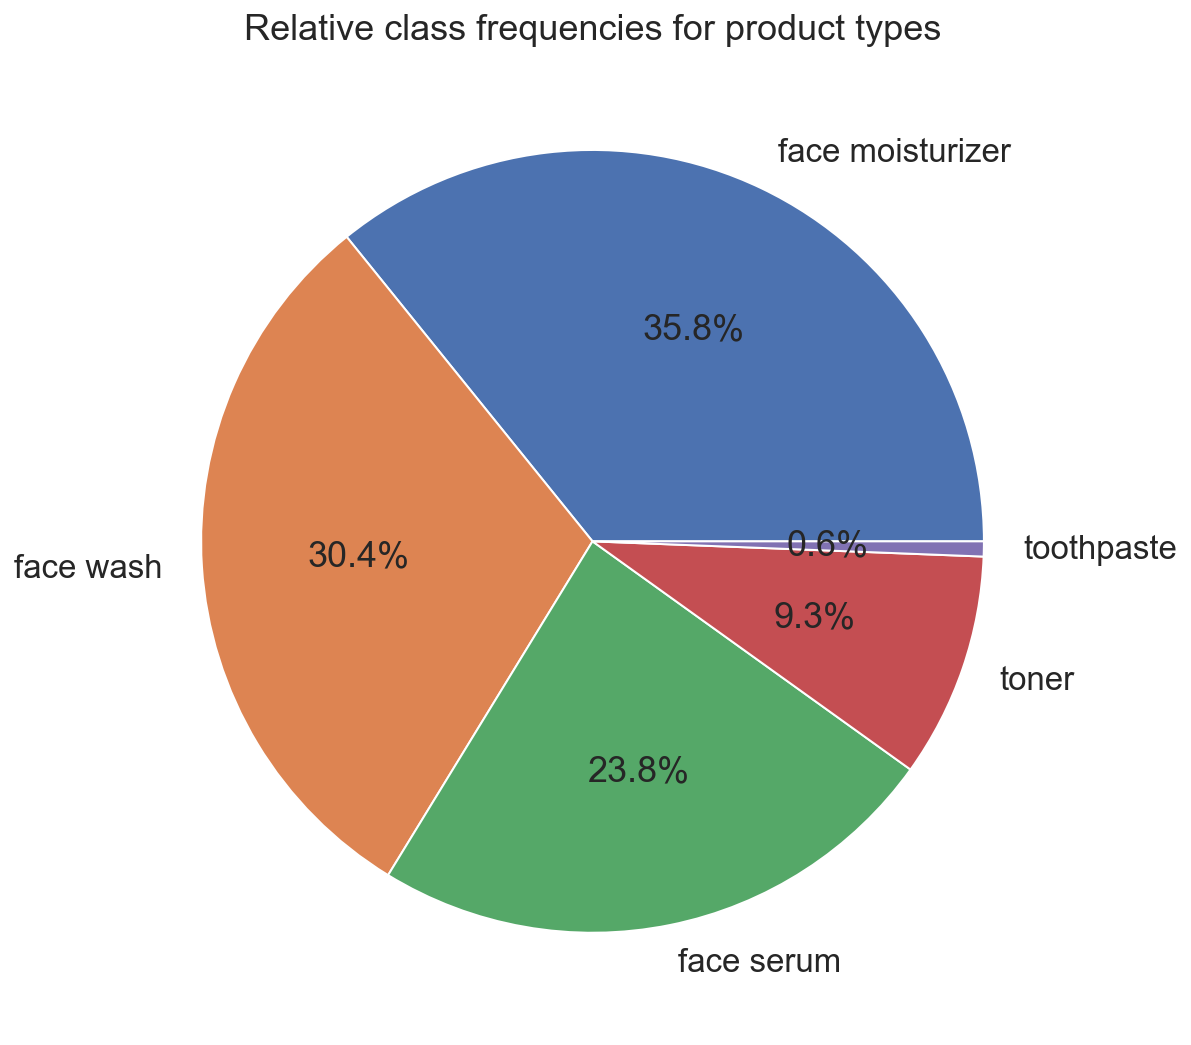

In [16]:
df_prod_agg['product_type'] \
            .value_counts() \
            .plot.pie(autopct='%1.1f%%',
                      title='Relative class frequencies for product types',
                      ylabel='')

- Some imbalance, particularly in face serum and toner relative to face wash and face moisturizer and the toothpaste control

<AxesSubplot:title={'center':'Relative class frequencies for ground truth labels'}>

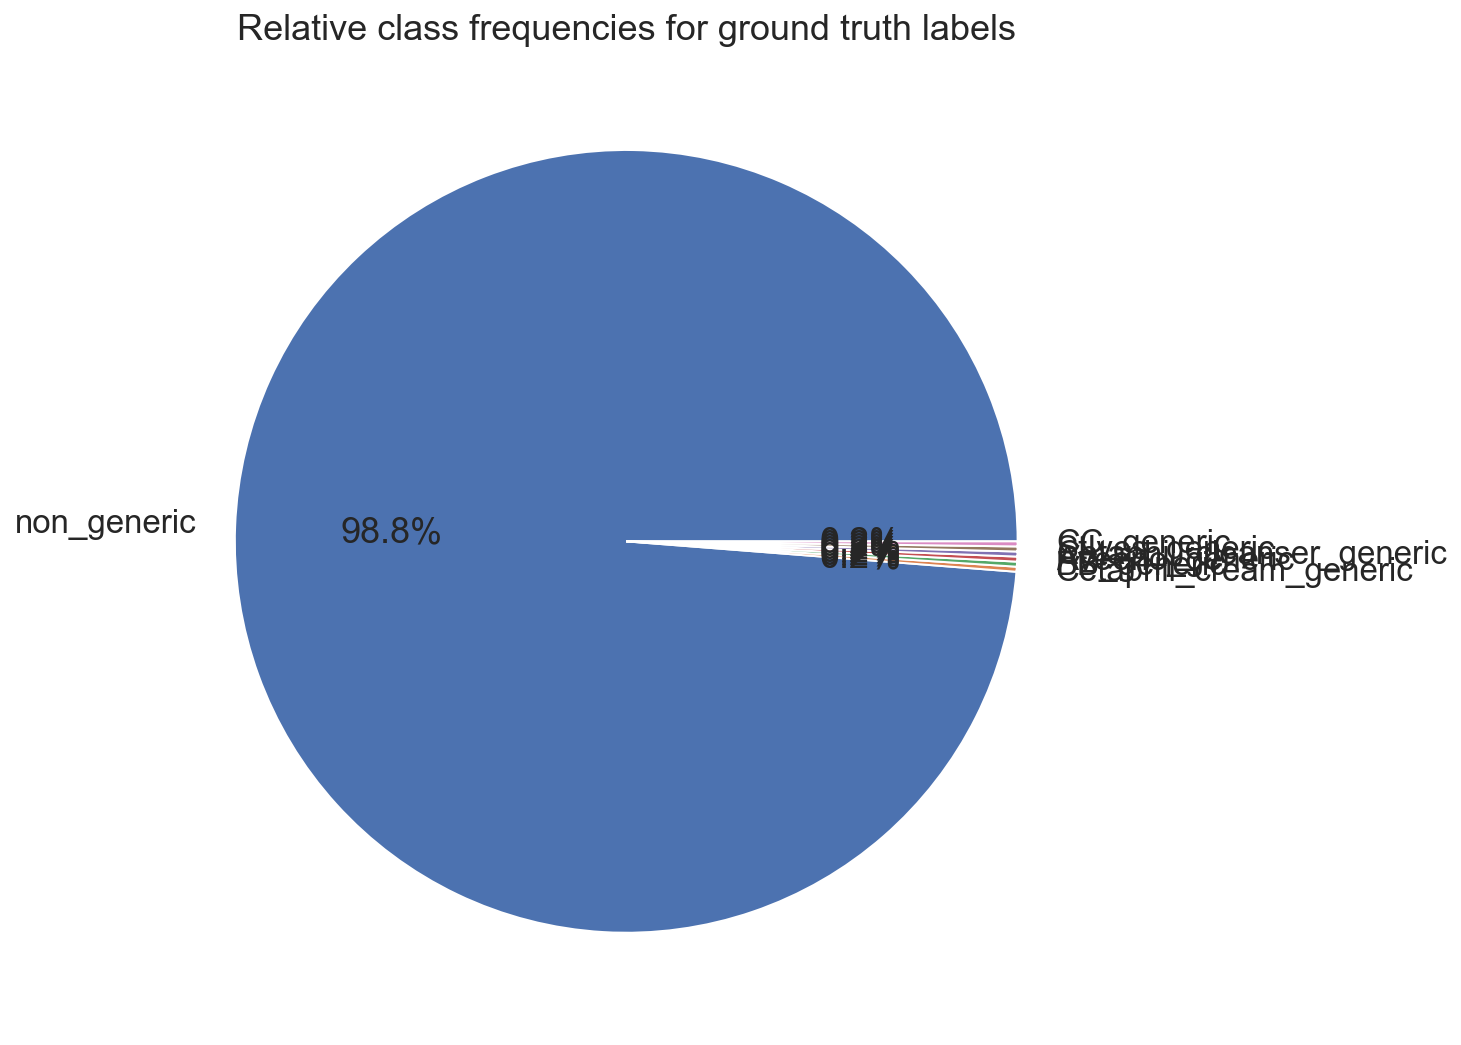

In [17]:
df_prod_agg['brand_generic'] \
            .value_counts() \
            .plot \
            .pie(autopct='%1.1f%%',
                 title='Relative class frequencies for ground truth labels',
                 ylabel='')

**Pivot df from long to wide for ingredients as columns**

In [18]:
# Expand ingredient lists per product to a 
# row for each ingredient with repeated rows
# for each product

df_ingred = df_prod_agg.explode('ingred_rev')

**Convert long df to wide with ingredients as the columns**

In [19]:
# Create a column of 1's for the values to indicate presence of an ingredient

df_ingred['fill_value'] = 1

In [20]:
pivot_indices = (
   ['product','use_category','product_type','brand_generic',
    'brand','size','price','ratings','total_reviews',
    'link']
)

In [21]:
# Fill NAs with "blank" text
# Can't do dropna=False b/c of a memory issue
# NaNs in some of the non-relevant columns of the brand_generics
# So those get dropped from pivoting if NaNs aren't replaced

df_ingred = df_ingred.fillna("blank")

In [22]:
# Pivot table from long to wide 

ingred_counts = pd.pivot_table(df_ingred, values='fill_value',
                                 index=pivot_indices, 
                                 columns='ingred_rev',
                                 fill_value=0,
                                 aggfunc=np.sum,
                                 dropna=True) \
                  .reset_index()       

In [23]:
# Rename column name index to none

ingred_counts.columns.names = [None]

**Split training and test sets using stratification for class imbalance**

In [24]:
# Function to return training and test set splits 

def get_train_test(target, df, test_size=0.2):
    '''
    Purpose: Return train and test set splits based on the target variable and
    data frame. Since the target is categorical in this case, splits are
    stratified. 
    
    target: the string name of the dataframe column with the target variable
    df: a pandas dataframe holding the features
    '''
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = (
        train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
    )
    return X_train, X_test, y_train, y_test

In [25]:
# Split into train and test for prod type

X_train_prodtype, X_test_prodtype, y_train_prodtype, y_test_prodtype = (
    get_train_test('product_type', ingred_counts)
)

In [26]:
# Check class proportions are equal in train and test set

print('Training set relative class frequencies')
y_train_prodtype.value_counts()/len(y_train_prodtype)

Training set relative class frequencies


face moisturizer    0.357419
face wash           0.304516
face serum          0.238710
toner               0.092903
toothpaste          0.006452
Name: product_type, dtype: float64

In [27]:
print('Test set relative class frequencies')
y_test_prodtype.value_counts()/len(y_test_prodtype)

Test set relative class frequencies


face moisturizer    0.360825
face wash           0.304124
face serum          0.237113
toner               0.092784
toothpaste          0.005155
Name: product_type, dtype: float64

In [28]:
# Split into train and test for generic labels
# Note test size is 0.5 because there are so few instances of each class!
# Otherwise, for smaller test sizes, we don't get one of each class
# instance in both the training and the test sets

X_train_brandgen, X_test_brandgen, y_train_brandgen, y_test_brandgen = (
    get_train_test('brand_generic', ingred_counts, test_size=0.5)
)

In [29]:
X_train_brandgen.shape

(484, 1642)

In [30]:
X_test_brandgen.shape

(485, 1642)

In [31]:
# Check class proportions are equal in train and test set

print('Training set relative class frequencies')
y_train_brandgen.value_counts()/len(y_train_brandgen)

Training set relative class frequencies


non_generic                  0.987603
BB_generic                   0.002066
Cetaphil_cream_generic       0.002066
Cetaphil_cleanser_generic    0.002066
Aveeno_generic               0.002066
StIves_generic               0.002066
CC_generic                   0.002066
Name: brand_generic, dtype: float64

In [32]:
print('Test set relative class frequencies')
y_test_brandgen.value_counts()/len(y_test_brandgen)

Test set relative class frequencies


non_generic                  0.987629
Aveeno_generic               0.002062
Cetaphil_cleanser_generic    0.002062
Cetaphil_cream_generic       0.002062
StIves_generic               0.002062
BB_generic                   0.002062
CC_generic                   0.002062
Name: brand_generic, dtype: float64

In [33]:
y_train_brandgen.head()

458    non_generic
420    non_generic
449    non_generic
295    non_generic
807    non_generic
Name: brand_generic, dtype: object

## TF-IDF 

- Need to create term frequency matrix grouped by product 
- Can't use the sklearn TF-IDF vectorizer because of the long format, e.g. multiple rows of ingredients for each product since it will read each ingredient product combination as a separate product

**Transform term frequency matrix to idf**

In [34]:
# Get product info columns without product

prod_info = [string for string in pivot_indices if string != 'product']

In [36]:
def filter_string(list_of_strings, string_to_remove):
    """
    Purpose: filters a string(s) from a list of strings
    Returns: a list without the indicated string(s)
    string_to_remove: MUST BE A LIST
    """
    new_list = [string for string in list_of_strings \
                    if string not in string_to_remove]
    return new_list

In [37]:
def get_prod_info(df, col_to_remove=[]):
    """
    Purpose: returns ingredient col names and product row names from df 
        to be assigned to tf-idf df
    col_to_remove: list, columns in prod info that are not present in the
        df and need to be removed from prod info since they are not present
        in that df. 
    """
    # Extract ingredient col names
    ingred_cols = df.drop(col_to_remove,
                               axis=1).columns.values
    # Extract product row names
    prod_names = df['product'].values
    return ingred_cols, prod_names

In [38]:
# get column and product names for tf-idf dataframe

brandgen_ingred_names, brandgen_prod_names = (
    get_prod_info(ingred_counts, col_to_remove=prod_info)
)

X_train_brandgen_ingred_names, X_train_brandgen_prod_names = (
    get_prod_info(X_train_brandgen,
                  col_to_remove=filter_string(prod_info,['brand_generic']))
)

X_test_brandgen_ingred_names, X_test_brandgen_prod_names = (
    get_prod_info(X_test_brandgen,
                  col_to_remove=filter_string(prod_info,['brand_generic']))
)

In [39]:
def get_tf(df, col_to_keep):
    """
    Purpose: Get term frequencies from dataframe
    Returns the tf matrix (not df!)
    col_to_keep: List of strings. These should be ingredient column names.
    """
    # Select columns with product name and ingredients only
    # This removes the other columns, e.g. product info 
    df = df[df.columns.intersection(col_to_keep)].set_index(keys='product')
    # convert df to tf matrix
    ingred_tf = df.to_numpy()
    return ingred_tf

**Calculate IDF values for frequency matrix**

In [40]:
def reorder_first_cols(df, col_order):
    '''
    Reorder columns in dataframe with col_order as a list of column names
    in the order you want them in to appear at the beginner of the dataframe.
    The rest of the columns will remain in the same order as before. 
    '''
    # Create new column ordering
    new_col_order = (
          col_order + [col for col in df.columns if col not in col_order]
    )
    # Reindex columns based on new order
    df = df.reindex(columns=new_col_order)
    
    return df

In [41]:
def get_idf(tf_matrix, col_names, prod_names):
    """
    Purpose: Get idf values from matrix of term frequencies.
    Returns df of tf-idf values
    tf_matrix: Term frequency matrix from get_tf() above
    col_names: List of column names for tf_matrix used when constructing df
    prod_names: List of row names for products in the tf-idf df when 
        constructing the tf-idf df
    """
    # Import tfidf transformer
    from sklearn.feature_extraction.text import TfidfTransformer
    # Set transformer arguments 
    transformer = TfidfTransformer(norm='l2',
                               use_idf=True, smooth_idf=True,
                               sublinear_tf=True)
    # Get the TF-IDF weighted ingredient matrix
    tfidf_res = transformer.fit_transform(tf_matrix)
    # Convert to df
    df_tf_idf = pd.DataFrame(tfidf_res.toarray())
    # Add ingredient column names
    df_tf_idf.columns = col_names
    # add product names to df
    df_tf_idf['product'] = prod_names
    # Re-order columns with product being first
    df_tf_idf = reorder_first_cols(df_tf_idf, ['product'])
    return df_tf_idf

In [42]:
def get_tf_idf(df, col_names, prod_names):
    """
    Purpose: get tf-idf matrix from a frequency count table and convert to a
    pandas df. Return the df.
    """
    # Get term frequency matrix for ingredients for brand generic
    ingred_tf = get_tf(df, col_to_keep=col_names)
    # Get idf values 
    df_tf_idf = get_idf(ingred_tf, 
                        col_names=filter_string(col_names, 'product'),  
                        prod_names=prod_names)
    return df_tf_idf

In [43]:
# Get tf-idf values

df_tf_idf = get_tf_idf(ingred_counts,
                       brandgen_ingred_names, 
                       brandgen_prod_names)

df_train_tf_idf = get_tf_idf(X_train_brandgen,
                             X_train_brandgen_ingred_names,
                             X_train_brandgen_prod_names)

df_test_tf_idf = get_tf_idf(X_test_brandgen,
                            X_test_brandgen_ingred_names,
                            X_test_brandgen_prod_names)

## Ingredient weighting 

### Ordinal encoding

### Ordinal encoding for ingredients

In [44]:
# Get unique products in df

prod_original = ingred_counts['product'].values
prod_train = X_train_brandgen['product'].values
prod_test = X_test_brandgen['product'].values

In [45]:
# Subset original long ingredient df for only products in the training set

df_original_ingred = df_ingred.query('product in @prod_original').copy()
df_train_ingred = df_ingred.query('product in @prod_train').copy()
df_test_ingred = df_ingred.query('product in @prod_test').copy()

In [46]:
def add_ord(df):
    """
    Purpose: Create new column with ordinal encodings for ingredient 
    order within each product 
    Returns: dataframe with ordinal encodings
    """
    # Create temporary placeholder constant for ordering
    df['ingred_value'] = 1
    # Add order numbering for ingredients within each product
    df['ingred_order'] = (
        df.groupby('product')['ingred_value'] \
                 .rank(method="first")
    )
    # Count total number of ingredients per product and expand 
    # result into main df
    df = df.assign(
        total_ingred = df.groupby('product')['ingred_order'] \
                                .transform('max')
    )
    # Take difference of ordinal max from ingredient order to get ordinal
    # values for ingredients in decreasing order
    # Add 1 so that the ingredient with the smallest concentration is
    # 1 and not 0 (because 0 would mean it is not present)
    df['ingred_ordinal'] = (
        (df["total_ingred"] - df["ingred_order"])+1
    )
    return df

In [47]:
# Add ordinal weighting to ingredients

df_orginal_ingred_ord = add_ord(df_original_ingred)
df_train_ingred_ord = add_ord(df_train_ingred)
df_test_ingred_ord = add_ord(df_test_ingred)

In [48]:
def scale_ord(df):
    """
    Scale by the number of ingredients in the product so products with 
    different numbers of ingredients are on the same scale
    Minus 1 because added 1 before so last ingredient would not be zero
    """
    df['ingred_ordinal_sc'] = (
        df['ingred_ordinal']/(df["total_ingred"])
    )
    return df

In [49]:
# Scale ordinal encodings

df_orginal_ingred_ord_sc = scale_ord(df_orginal_ingred_ord)
df_train_ingred_ord_sc = scale_ord(df_train_ingred_ord)
df_test_ingred_ord_sc = scale_ord(df_test_ingred_ord)

In [57]:
def add_ord_wts(df_ord_wts, df_tf_idf, df_ingred, add_prodtype=False):
    """
    Purpose: Multiplies scaled ordinal encodings to tf-idf 
    for ingredient values
    Returns: df
    df_ord_wts: df of ingredients with ordinal weightings that
        are also scaled
    df_tf_idf: tf_idf df
    add_prodtype: add product_type to prod info. 
    """
    # Convert ordinal weights df from long to wide 
    # with ingredients as the columns and 
    # products as the rows
    df_ingred_ord = df_ord_wts.pivot_table(
                                            index='product',
                                            columns='ingred_rev',
                                            values='ingred_ordinal_sc',
                                            aggfunc='max',
                                            fill_value=0) \
                              .reset_index()   
    # Rename column name index to none
    df_ingred_ord.columns.names = [None]
    # Multiply ingredient tf-idf values by ordinal weightings
    df_ingred_wt = (
        df_tf_idf.drop('product',axis=1) \
                 .mul(df_ingred_ord.drop('product',axis=1),
                      fill_value=0)
    )
    # Add product names and reorder
    df_ingred_wt['product'] = df_tf_idf['product']
    # Product information
    prod_info = ['use_category','brand', 'brand_generic',
                  'size','price','link']
    # Add product type 
    if add_prodtype:
        prod_info.append(str('product_type'))
    # Extract product information for first row only 
    # (same values for all rows of each product)
    # Use category, price, link, brand, size    
    df_prod_info = (
            df_ingred.groupby('product') \
            [prod_info].first().reset_index()
        )
    # Add product info to main ingredient df and reorder
    df_ingred_final = (
        pd.merge(df_ingred_wt, df_prod_info, how='inner',on='product')
    )
    if add_prodtype:
        cols_order = ['product', 'use_category','brand','brand_generic',
                      'product_type', 'size','price','link']
    else:
        cols_order = ['product', 'use_category','brand','brand_generic',
                      'size','price','link']
    df_ingred_final = reorder_first_cols(df_ingred_final, cols_order)
    return df_ingred_final

In [58]:
# Weight tf-idf values by ordinal weights

df_original_ingred_final = add_ord_wts(df_orginal_ingred_ord_sc,
                                       df_tf_idf,
                                       df_original_ingred,
                                      add_prodtype=True)
df_train_ingred_final = add_ord_wts(df_train_ingred_ord_sc,
                                    df_train_tf_idf,
                                    df_train_ingred)
df_test_ingred_final = add_ord_wts(df_test_ingred_ord_sc,
                                   df_test_tf_idf, 
                                   df_test_ingred)

## Dimensionality Reduction: TSVD

In [86]:
# Import libraries

from sklearn.decomposition import TruncatedSVD
import seaborn as sns

In [87]:
# Create feature matrix

cols_to_drop = ['use_category','brand','brand_generic', 'size','price','link']
df_train_feat = df_train_ingred_final.drop(cols_to_drop,
                                     axis=1).set_index('product')
df_test_feat = df_test_ingred_final.drop(cols_to_drop,
                                     axis=1).set_index('product')

cols_to_drop_original = cols_to_drop + [str('product_type')]
df_original_feat = df_original_ingred_final.drop(cols_to_drop_original,
                                                 axis=1).set_index('product')

In [88]:
# Create a TSVD instance

tsvd = TruncatedSVD(n_components=400, random_state=42)

In [89]:
# Conduct TSVD on features matrix

tsvd_original_res = tsvd.fit(df_original_feat)
df_original_tsvd = pd.DataFrame(tsvd.transform(df_original_feat))

tsvd_train_res = tsvd.fit(df_train_feat)
df_train_tsvd = pd.DataFrame(tsvd.transform(df_train_feat))

In [93]:
def add_prod_info(tsvd_df, original_df, col_names, prod_names_col,
                  prod_type=False):
    """
    Purpose: Add product information to TSVD dataframe
    Returns: dataframe with product information in rows and columns
    tsvd_df: df with tsvd results
    original_df: df before tsvd with product information
    col_names: List of strings of column names to be added into tsvd df
    prod_names_col: Name of column with product names, string
    prod_type: Whether to include product type in the product info
    """
    # Add product names
    tsvd_df['product']=original_df[prod_names_col]
    # Copy columns to new df
    col_copy = original_df[col_names].copy()
    # Copy product names to col names df
    col_copy['product'] = original_df[prod_names_col]
    # Join with tsvd df on product
    tsvd_df = pd.merge(tsvd_df, col_copy, how='inner', on='product')
    # Reorder df columns
    if prod_type:
        cols_order = ['product', 'use_category','brand','brand_generic',
                      'product_type', 'size','price','link']
    else:
        cols_order = ['product', 'use_category','brand','brand_generic',
                      'product_type', 'size','price','link']
    tsvd_df = reorder_first_cols(tsvd_df, cols_order)
    return tsvd_df

In [97]:
# Add product info to tsvd df

df_original_tsvd_export = add_prod_info(df_original_tsvd,
                                         df_original_ingred_final,
                                         cols_to_drop_original,
                                         'product',
                                        prod_type=True)

In [99]:
# Export tsvd df for analysis

directory_name = '/data/clean/'
file_name = 'data_tsvd_full.csv'
df_original_tsvd_export.to_csv(rpath+directory_name+file_name)

Text(0, 0.5, 'Cumulative explained variance')

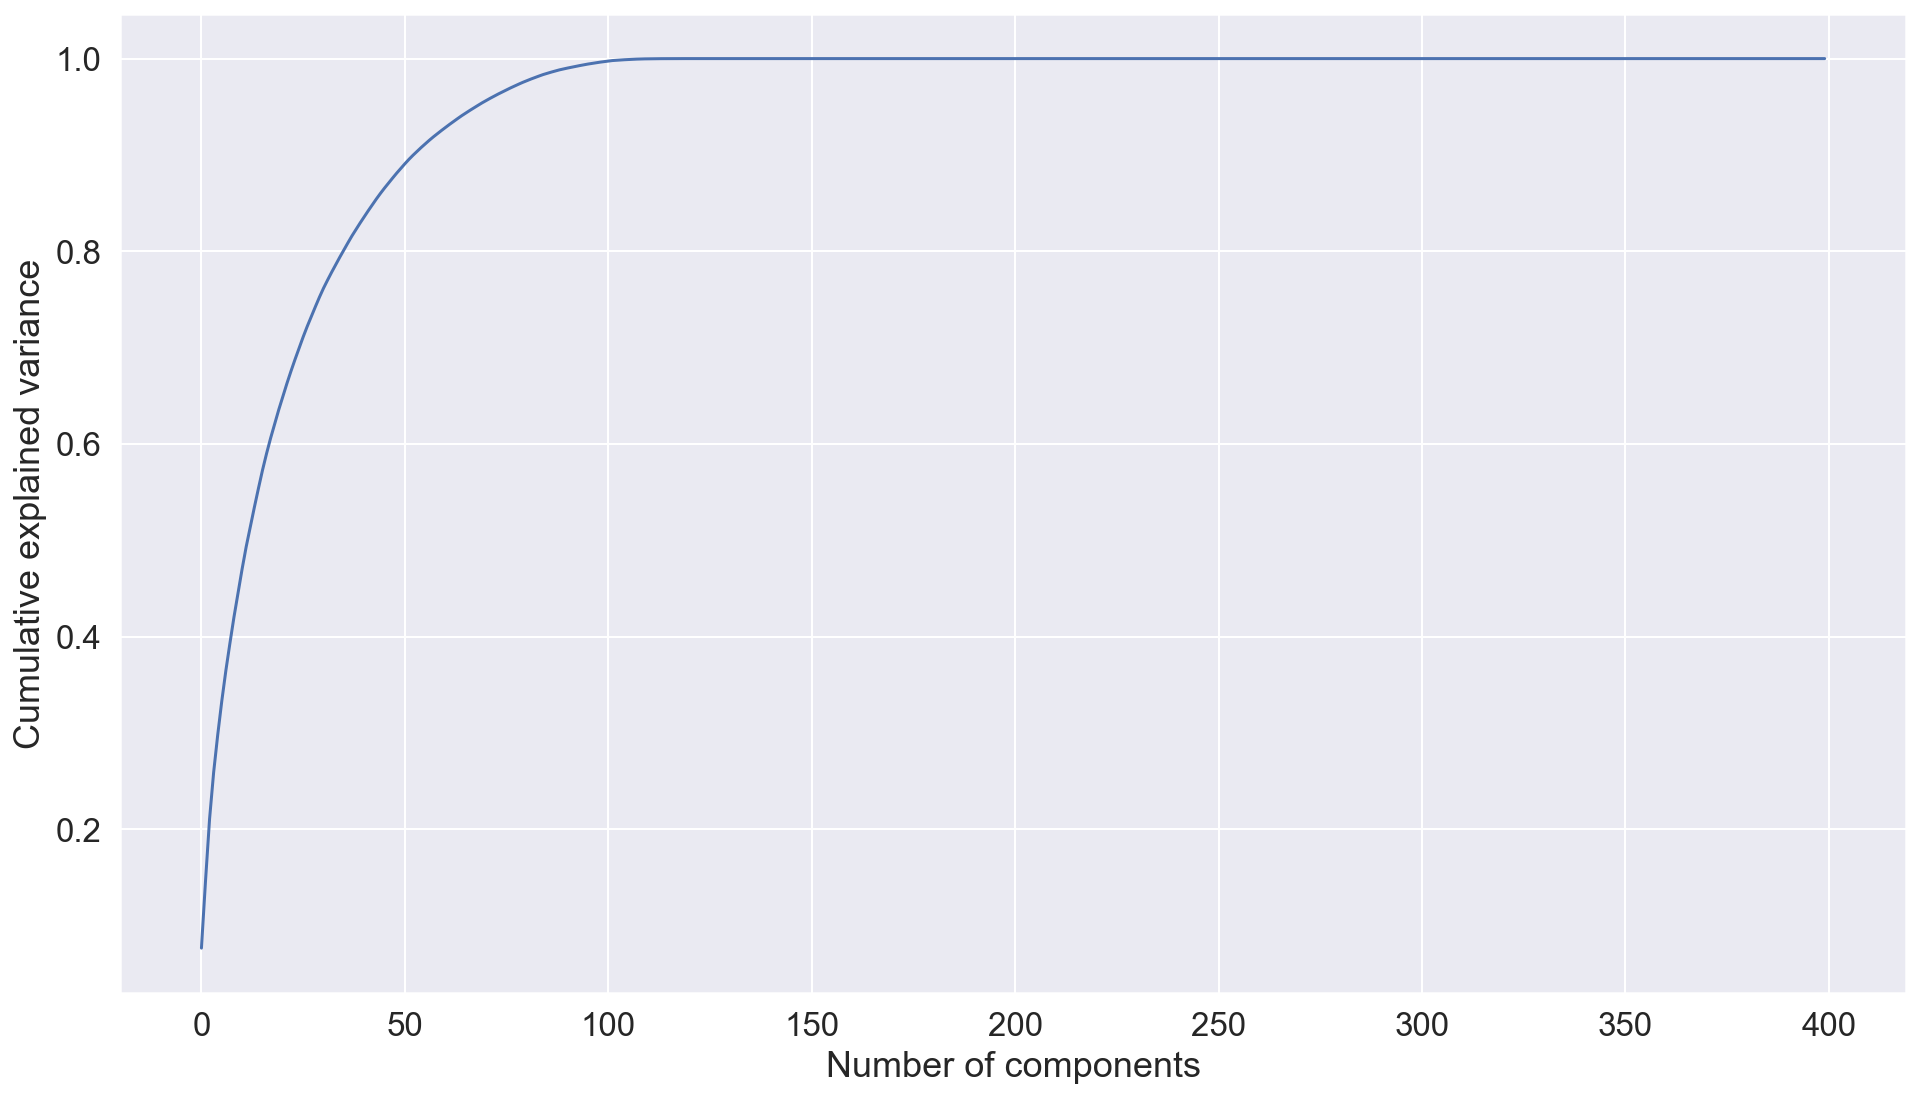

In [829]:
# Plot cumulative explained variance vs. number of components for original

import matplotlib.pyplot as plt
plt.plot(np.cumsum(tsvd_original_res.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Text(0, 0.5, 'Cumulative explained variance')

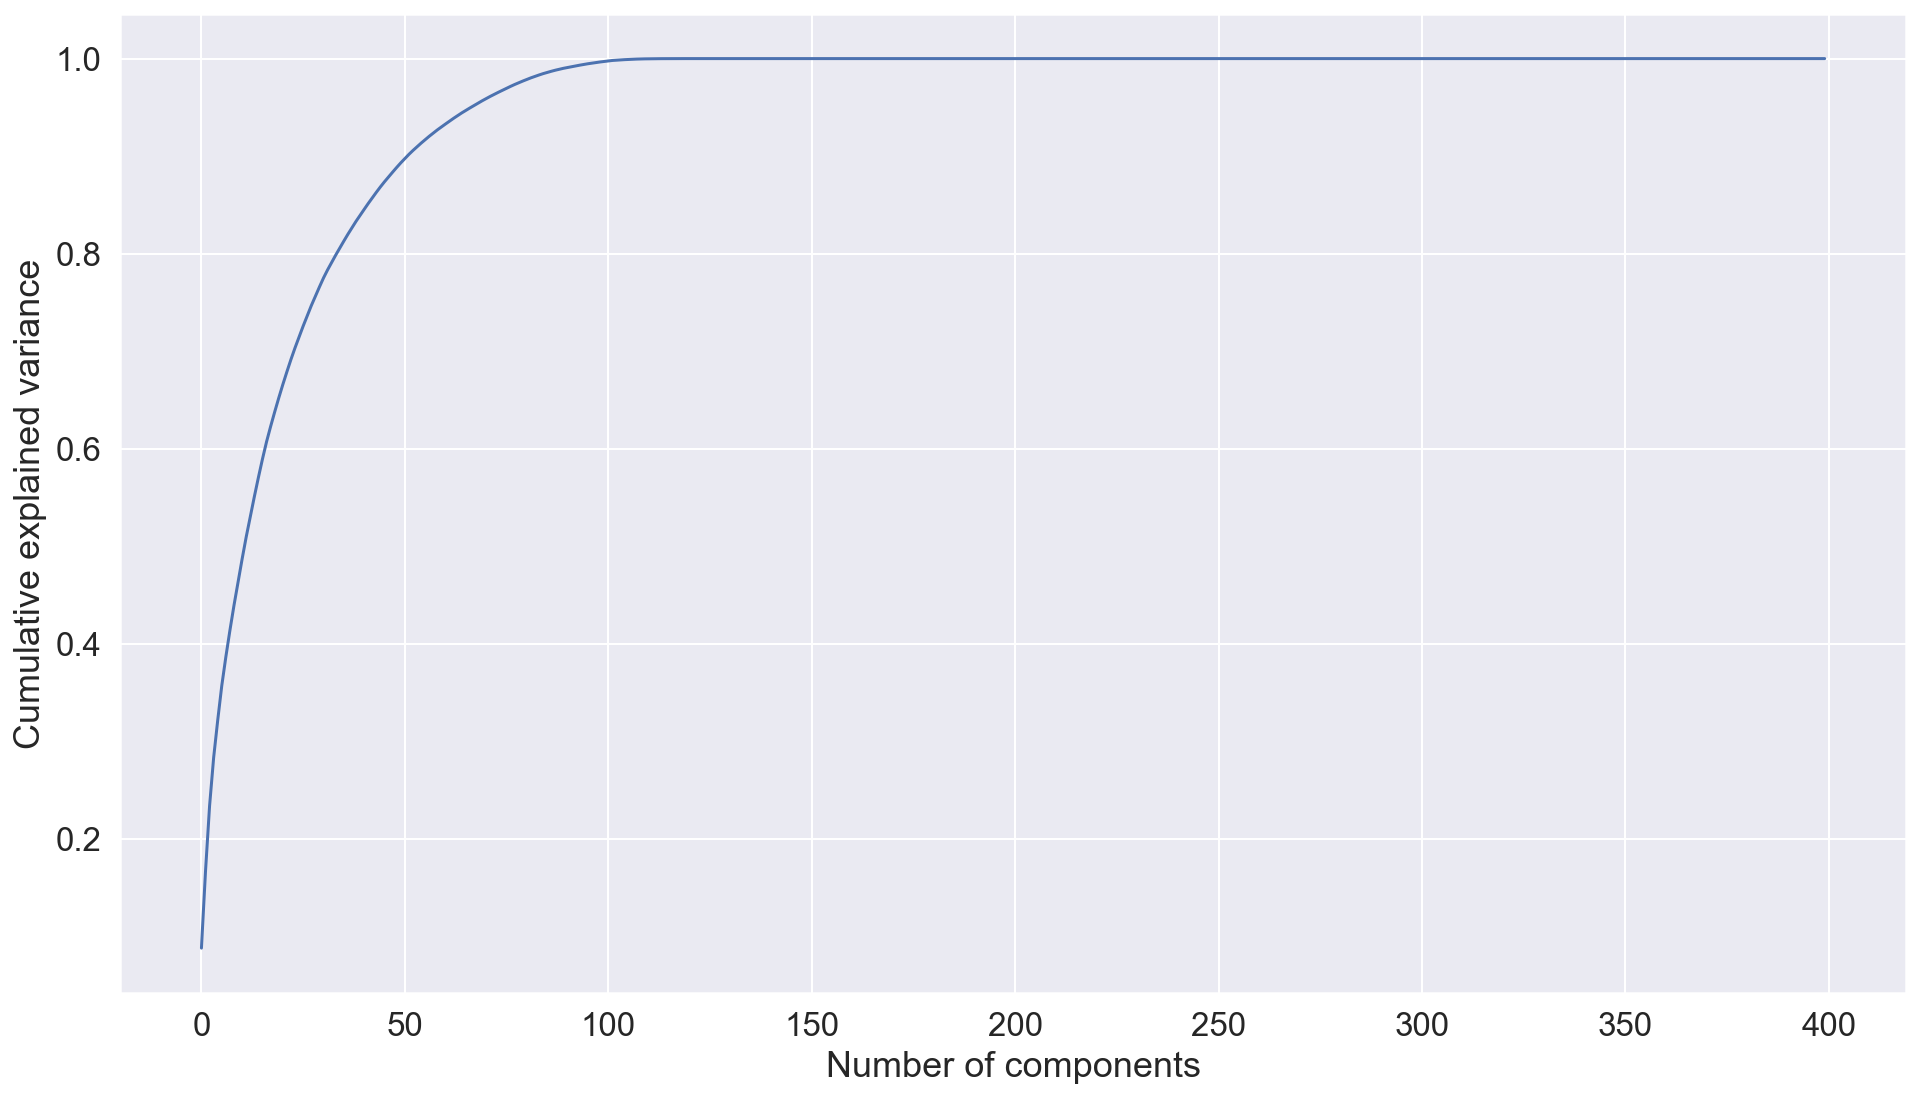

In [428]:
# Plot cumulative explained variance vs. number of components for train

import matplotlib.pyplot as plt
plt.plot(np.cumsum(tsvd_train_res.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [414]:
# Check variance explained at 100 components

tsvd_res.explained_variance_ratio_[0:80].sum()

0.9771234523694606

In [519]:
# Transform test set from training

df_tsvd_test = pd.DataFrame(tsvd_res.transform(df_test_feat))